<a href="https://colab.research.google.com/github/rachelyayra/Fire-segmentation-with-FCN/blob/main/FCN16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Fire Segmentation with Fully Convolutional networks

- This notebook implements FCN-16, an architecture usually used for image segmentation
- This implementation has Intersection over Union(IoU) score as: ** 0.65374625**

Table of Contents:

1. Data Preprocessing
2. Model Building and Training
4. Tests
5. Evaluation
2. Save Model



### 1. Data Preprocessing

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"racheladjoe","key":"29f5e91018af6dd4a059fa0d341c1206"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [8]:
!kaggle datasets download -d diversisai/fire-segmentation-image-dataset

100% 470M/472M [00:16<00:00, 35.0MB/s]
100% 472M/472M [00:16<00:00, 30.6MB/s]


In [ ]:
!unzip fire-segmentation-image-dataset.zip


 IMPORT RELEVANT PACKAGES

In [10]:
import os
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from PIL import Image
from sklearn.model_selection import train_test_split
import pickle

In [11]:
# Ground Truth Folder Path
gt_file_path = '/content/Segmentation_Mask/Fire'
# Image Folder Path
im_file_path = '/content/Image/Fire'

In [12]:
classes = os.listdir(gt_file_path)

In [13]:
clas = os.listdir(im_file_path)

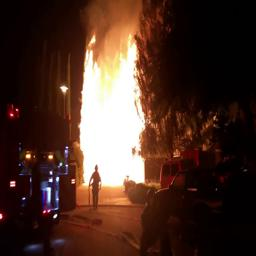

In [14]:
# Sample Images and
Image.open(os.path.join(im_file_path, classes[0]))

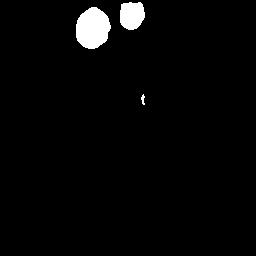

In [15]:
Image.open(os.path.join(gt_file_path, classes[0]))

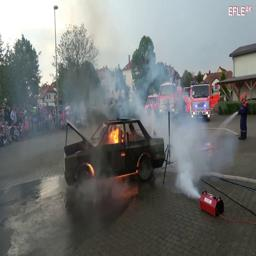

In [16]:
Image.open(os.path.join(im_file_path, classes[1]))

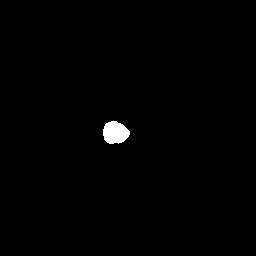

In [17]:
Image.open(os.path.join(gt_file_path, classes[1]))

CREATE TRAINING DATASET

In [18]:
def create_dataset_IM(img_folder):
    img_data_array=[]
    for dir1 in os.listdir(img_folder):
      if (len(img_data_array) == 1500):
        break
      image_path= os.path.join(img_folder, dir1)
      image= np.array(Image.open(image_path))
      # image =np.array(image).reshape(-1, 512, 512, 1)
      image = image.astype('float32')
      image /= 255
      img_data_array.append(image)
    return img_data_array


In [19]:
def create_dataset_GT(img_folder):
    img_data_array=[]
    for dir1 in os.listdir(img_folder):
      if (len(img_data_array) == 1500):
        break
      image_path= os.path.join(img_folder, dir1)
      image= np.array(Image.open(image_path))
            # image =np.array(image).reshape(-1, 512, 512, 1)
      image = image.astype('float32')
      image /= 255
      img_data_array.append(image)
    return img_data_array


In [20]:
groundTruth = create_dataset_GT(gt_file_path)

In [21]:
imageTruth = create_dataset_IM(im_file_path)

In [22]:
len(groundTruth)

1500

In [23]:
# Information on Images
imageTruth
dim1 = len(imageTruth)
dim2 = len(imageTruth[0])
dim3 = len(imageTruth[0][0])
dim4 = len(imageTruth[0][0][0])

print(dim1,dim2, dim3, dim4)

1500 256 256 3


In [24]:
# Reshaping Images
X =np.array(imageTruth).reshape(-1, 256, 256, 3)

In [25]:
y=np.array(groundTruth).reshape(-1, 256, 256, 1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
y_train[0].shape

(256, 256, 1)

In [28]:
X_train[0].shape

(256, 256, 3)

### 2. Model Building and Training

In [29]:
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.layers import  Activation, Flatten, Dense, Conv2D,  Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Input, Add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.metrics import IoU
import tensorflow as tf

In [30]:
def createFCN16():
  c = Input(shape=(256, 256, 3))
  j = layers.Conv2D(8,(2,2), activation= 'relu', padding = 'same' )(c)
  k = layers.Conv2D(8,(2,2), activation= 'relu', padding = 'same' )(j)
  l = layers.MaxPooling2D((2,2))(k)
  m = layers.Conv2D(16,(2,2), activation= 'relu', padding = 'same' )(l)
  n = layers.Conv2D(16,(2,2), activation= 'relu', padding = 'same' )(m)
  o = layers.MaxPooling2D((2,2))(n)
  p = layers.Conv2D(32,(2,2), activation= 'relu' , padding = 'same' )(o)
  q = layers.Conv2D(32,(2,2), activation= 'relu', padding = 'same' )(p)
  r = layers.MaxPooling2D((2,2))(q)
  s = layers.Conv2D(64,(2,2), activation= 'relu' , padding = 'same' )(r)
  t = layers.Conv2D(64,(2,2), activation= 'relu', padding = 'same' )(s)
  u = layers.MaxPooling2D((2,2))(t)
  v = layers.Conv2D(128,(2,2), activation= 'relu',padding = 'same'  )(u)
  w = layers.Conv2D(128,(2,2), activation= 'relu', padding = 'same' )(v)
  x = layers.MaxPooling2D((2,2))(w)
  y = layers.Conv2D(256,(2,2), activation= 'relu', padding = 'same' )(x)
  z = layers.Conv2D(256,(2,2), activation= 'relu', padding = 'same' )(y)
   # Decoding layers with skip connections
  up1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(z)
  conv1 = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(u)
  skip1 = Add()([conv1, up1])
  a = layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(skip1)


  b = layers.Conv2D(1,(1,1), padding='same', activation = 'sigmoid')(a)

  model = Model(c, b)
  model.compile(
  optimizer="Adam",
  loss= 'binary_crossentropy',
  metrics=['accuracy'],
  )
  return model

In [31]:
fcn = createFCN16()

In [32]:
fcn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          104       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 8)          264       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 8)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
num_epochs = 50
history = fcn.fit(
    X_train,y_train, epochs = num_epochs, batch_size = 32, validation_split= 0.3
    )


### 3. Tests

In [34]:
def test_image(image):
  test = image.reshape(-1,256,256,3)
  prediction = fcn.predict(test)
  pred = prediction.reshape(256,256)
  real_pred = (pred > 0.3).astype(int)
  return pred , real_pred

In [35]:
def real_test(image):
  test = image.reshape(-1,256,256,3)
  prediction = fcn.predict(test)
  pred = prediction.reshape(256,256)
  real_pred = (pred > 0.3).astype(int)
  return real_pred

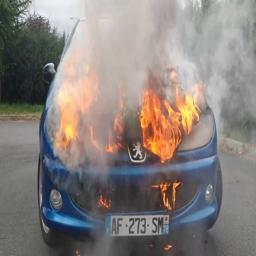

In [36]:
Image.fromarray((X_test[0]* 255).astype(np.uint8))

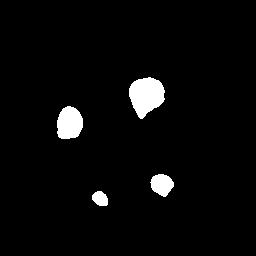

In [37]:
Image.fromarray((y_test[0].reshape(256,256)*255).astype(np.uint8))

In [38]:
# Test Image 1
raw1, real1 = test_image(X_test[0])

1/1 [==============================] - 0s 485ms/step


RAW PREDICTION

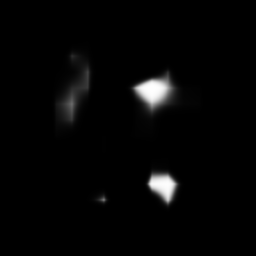

In [39]:
Image.fromarray((raw1* 255).astype(np.uint8))

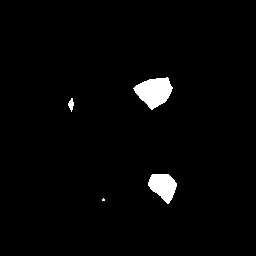

In [40]:
Image.fromarray((real1* 255).astype(np.uint8))

### 4. Evaluation

In [41]:
import tensorflow as tf

# Create a MeanIoU object
iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)  # 2 classes: background and region of interest

# Update the metric with the masks
iou_metric.update_state(y_test[0], real1)

# Calculate and print the IoU metric
iou_value = iou_metric.result().numpy()
print("IoU:", iou_value)

IoU: 0.6630705


In [ ]:
predicted_masks = [real_test(i) for i in X_test]

In [43]:
len(y_test)

495

In [44]:
len(predicted_masks)

495

In [45]:
for predicted_mask, ground_truth_mask in zip(predicted_masks, y_test):
    # Convert masks to integer values (0 or 1)
    # predicted_mask = tf.constant(predicted_mask, dtype=tf.int32)
    # ground_truth_mask = tf.constant(ground_truth_mask, dtype=tf.int32)

    # Update the metric with the masks
    iou_metric.update_state(ground_truth_mask, predicted_mask)

# Calculate and print the mean IoU metric for all masks
mean_iou_value = iou_metric.result().numpy()
print("Mean IoU:", mean_iou_value)

Mean IoU: 0.6660743


### 5. Save Model

In [47]:
filename = '/content/drive/MyDrive/FCN-MODELS/FCN16.pkl'
pickle.dump(fcn, open(filename, 'wb'))